# POPPY Simulation: MagAO-X Surface Check (Master file)
## Notes: 
- This file has aberrations present due to PSDs on the optical surfaces.
- This version uses a CSV file to make an easier time to analyze the diffraction effect initiated by each optical surface and to allow for optical system changes. 
- There are different CSV files to evaluate different setups; each CSV file may be found in the data folder.
- The function definitions used in this file may be found here: https://github.com/jlumbres/magaox_poppy/blob/master/magaoxFunctions.py
- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.
- The FITS files generated in code (DM surfaces, PSF intensities at science plane) are not included in github because they are too large for github's storage space. However, one may obtain them by running this code.

## Major Update:
- The Science PSFs have been changed from PDR level. The PDR level notebooks was doubling the phase in the vAPP OPD mask and not allowing a full transmission for the vAPP transmission mask. This notebook has since corrected it.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
import magaoxFunctions as mf

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file. All distances between each MagAO-X element (after F/11 focal plane) can be found using Zemax Merit Function Editor (using RAG and QSUM)
- Current Zemax design version: 9.5

### Optical elements not implemented:
- ADC1
- ADC2
- 9mm Lyot Stop
- F-4 and F-5 (for version 9.5)

### To-do Tasks:
- Test against new surface maps.
- Create routine to study Tweeter DM adjustments

## Task 0: CSV Prescription Load

The system is stored as a CSV file describing each optics prescription and the distance between them. The CSV file also contains the surface map PSD files for each optical surface. At each F/number focal plane, the correction value has already been implemented, as defined from a previous file build.

In [2]:
rx_sys = mf.makeRxCSV('data/rxCSV/rx_magaox_v9.5_PSDset4.csv')

CSV file name: data/rxCSV/rx_magaox_v9.5_PSDset4.csv
The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD_folder', 'surf_PSD_filename', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')


Build the array that only calls for the mirrors (only the mirrors have the surfaces to examine)

In [3]:
mirrors_array = []
optics_names = []
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Type'] == 'mirror' or test_opt['Type'] == 'ref':
        mirrors_array.append(test_opt['Optical_Element_Number'])
        optics_names.append(test_opt['Name'])
        if test_opt['Type'] == 'ref':
            ref_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'Tweeter':
        tweeter_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']
    
    if test_opt['Name'] == 'M1':
        M1_num = test_opt['Optical_Element_Number']
        
telescope = mirrors_array

## Global variables for MagAO-X
<b>Current Setting</b>: 256 pix sample, 8x oversample; All files below are particular for this setting.

<b>PDR Level</b>: 512 pix sample, 3x oversample (holdover from PROPER examples)

In [4]:
# Global terms
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # sampling
beam_ratio = 0.125 # 8x oversample
M1_radius=rx_sys['Radius_m'][M1_num]*u.m

# vAPP files
vAPP_diam = 0.009 # units: meters, always 9mm diameter beam.
vAPP_pixelscl = vAPP_diam/npix # vAPP is sized to whatever the sampling is set.
vAPP_folder = 'data/coronagraph/'
vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
vAPP_opd_filename = 'vAPP_opd_mask_1PSF_256'

# Lyot plane pupil file
lyot_pupil_base = fits.open('data/PSDset2/MagAOX_f11_pupil_256_unmasked.fits')[0].data

# Spatial Frequency mapping routine
magKmap = mf.SpatFreqMap(M1_radius, npix)

# Tweeter DM control bandwidth
tweeter_BW = 24/(M1_radius.value*2)

# Tweeter DM diameter - from MagAO-X design: 19.2 x 18.8mm; use the smaller one
tweeter_diam = 0.0188 * u.m

tweeter_pixscl = tweeter_diam.value/npix

## Version: DM implemented

In [7]:
%%prun
# Version: 5x DM iteration

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set1_g0.9/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder
sci_intensity_folder = 'output/v9.5/s256os8x/set1/WithDM_g0.9/'
sci_intensity_prefix = 'SciPSF_WithDM_intensity_'

# Constants
num_DM_iteration = 5
gain = 0.9

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('Case: With DM')
print('*****')

for test_optic in telescope:
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # start with no DM surface applied
    tweeter_surf_prefix = 'DMsurf_' + rx_sys['Name'][test_optic] + '_'
    tweeter_surf_addr = tweeter_surf_folder + tweeter_surf_prefix
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    
    # DM iteration looping, 5 iterations
    for DM_count in range(0, num_DM_iteration):

        # build to Lyot plane
        magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
        lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
        lyot_phase_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
        
        # Calculate DM surface based on Lyot phase data
        calc_surf = mf.BuildLyotDMSurf(lyot_phase_data, npix, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength)

        # Get previous DM surface
        if DM_count == 0: # First run through
            DM_surf_prev = np.zeros((npix,npix))
        else:
            DM_surf_prev = fits.open(tweeter_surf_addr+str(DM_count-1)+'.fits')[0].data
        
        # metric to see surface change
        DM_metric = np.sum(np.absolute(np.nan_to_num(calc_surf/DM_surf_prev)))
        #DM_metric_list.append(DM_metric)
        print('DM iteration %s metric: %f' % (str(DM_count), DM_metric))
        
        # If this is the last iteration, then save the calculated surface as the surface for vAPP PSF
        if DM_count == (num_DM_iteration-1):
            # Set up next DM surface for full system PSF
            tweeter_loc = tweeter_surf_prefix + 'final'
            mf.writeOPDfile(calc_surf, tweeter_pixscl, tweeter_surf_folder + tweeter_loc + '.fits')
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_loc
        
        else:
            # New DM surface to apply
            DM_new_surf = DM_surf_prev + (gain*calc_surf)
            mf.writeOPDfile(DM_new_surf, tweeter_pixscl, tweeter_surf_addr + str(DM_count) + '.fits')

            # Set up next DM surface for the next DM iteration
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + str(DM_count)
    
    # Insert vAPP transmission and OPD optics overrides
    rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
    rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('%s surface test completed' % rx_sys['Name'][test_optic])

Surface check using sampling = 256.000000 px and oversampling = 8.000000
Case: With DM
*****


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

DM iteration 0 metric: inf
DM iteration 1 metric: 6753.669884
DM iteration 2 metric: 1356.226845
DM iteration 3 metric: 777.309723
DM iteration 4 metric: 554.518966
M1 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 7292.997091
DM iteration 2 metric: 1641.469754
DM iteration 3 metric: 897.624344
DM iteration 4 metric: 672.994503
M2 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 7435.400946
DM iteration 2 metric: 1833.466431
DM iteration 3 metric: 1467.998512
DM iteration 4 metric: 781.711538
M3 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 6732.326126
DM iteration 2 metric: 1331.153867
DM iteration 3 metric: 6439.225942
DM iteration 4 metric: 756.217023
F-1 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 6825.093930
DM iteration 2 metric: 1454.129809
DM iteration 3 metric: 867.394386
DM iteration 4 metric: 868.463004
K-1 surface test completed
DM iteration 0 metric: inf
DM iteration 1

In [8]:
%%prun
# Version: 4x DM iteration

# Open new CSV file
rx_sys = mf.makeRxCSV('data/rxCSV/rx_magaox_v9.5_PSDset4.csv')

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set4_g0.9/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder
sci_intensity_folder = 'output/v9.5/s256os8x/set4/WithDM_g0.9/'
sci_intensity_prefix = 'SciPSF_WithDM_intensity_'

# Constants
num_DM_iteration = 5
gain = 0.9

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('Case: With DM')
print('*****')

for test_optic in telescope:
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # start with no DM surface applied
    tweeter_surf_prefix = 'DMsurf_' + rx_sys['Name'][test_optic] + '_'
    tweeter_surf_addr = tweeter_surf_folder + tweeter_surf_prefix
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    
    # DM iteration looping, 5 iterations
    for DM_count in range(0, num_DM_iteration):

        # build to Lyot plane
        magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
        lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
        lyot_phase_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
        
        # Calculate DM surface based on Lyot phase data
        calc_surf = mf.BuildLyotDMSurf(lyot_phase_data, npix, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength)

        # Get previous DM surface
        if DM_count == 0: # First run through
            DM_surf_prev = np.zeros((npix,npix))
        else:
            DM_surf_prev = fits.open(tweeter_surf_addr+str(DM_count-1)+'.fits')[0].data
        
        # metric to see surface change
        DM_metric = np.sum(np.absolute(np.nan_to_num(calc_surf/DM_surf_prev)))
        #DM_metric_list.append(DM_metric)
        print('DM iteration %s metric: %f' % (str(DM_count), DM_metric))
        
        # If this is the last iteration, then save the calculated surface as the surface for vAPP PSF
        if DM_count == (num_DM_iteration-1):
            # Set up next DM surface for full system PSF
            tweeter_loc = tweeter_surf_prefix + 'final'
            mf.writeOPDfile(calc_surf, tweeter_pixscl, tweeter_surf_folder + tweeter_loc + '.fits')
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_loc
        
        else:
            # New DM surface to apply
            DM_new_surf = DM_surf_prev + (gain*calc_surf)
            mf.writeOPDfile(DM_new_surf, tweeter_pixscl, tweeter_surf_addr + str(DM_count) + '.fits')

            # Set up next DM surface for the next DM iteration
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + str(DM_count)
    
    # Insert vAPP transmission and OPD optics overrides
    rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
    rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('%s surface test completed' % rx_sys['Name'][test_optic])

CSV file name: data/rxCSV/rx_magaox_v9.5_PSDset4.csv
The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD_folder', 'surf_PSD_filename', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')
Surface check using sampling = 256.000000 px and oversampling = 8.000000
Case: With DM
*****


/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/jhen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in true_divide


DM iteration 0 metric: inf


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude


DM iteration 1 metric: 6737.758470
DM iteration 2 metric: 2471.024602
DM iteration 3 metric: 3198.032773
DM iteration 4 metric: 4045.002054
M1 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 6362.993337
DM iteration 2 metric: 2503.240047
DM iteration 3 metric: 3048.394585
DM iteration 4 metric: 8233.118066
M2 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 14955.570372
DM iteration 2 metric: 8088.499217
DM iteration 3 metric: 13960.271331
DM iteration 4 metric: 9991.429140
M3 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 7285.201783
DM iteration 2 metric: 2671.473267
DM iteration 3 metric: 3816.968970
DM iteration 4 metric: 4371.982863
F-1 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 6430.761444
DM iteration 2 metric: 2637.013865
DM iteration 3 metric: 2097.702341
DM iteration 4 metric: 3020.925344
K-1 surface test completed
DM iteration 0 metric: inf
DM iteration 1 metric: 7324.567

In [8]:
%%prun
# Version: 1x DM iteration

# Open new CSV file
rx_sys = mf.makeRxCSV('data/rxCSV/rx_magaox_v9.5_PSDset4.csv')

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set4/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder
sci_intensity_folder = 'output/v9.5/s256os8x/set4/WithDM/'
sci_intensity_prefix = 'SciPSF_WithDM_intensity_'

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('Case: With DM, single DM iteration, no gain implemented')
print('*****')

for test_optic in telescope:
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'

    # build to Lyot plane
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
    lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                display_intermediates=False,
                                return_intermediates=True)
    lyot_phase_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data

    # Calculate DM surface based on Lyot phase data
    calc_surf = mf.BuildLyotDMSurf(lyot_phase_data, npix, lyot_pupil_base, magKmap, tweeter_BW, 
                   testWavelength)
    tweeter_surf_file_loc = tweeter_surf_folder + 'DMsurf_' + rx_sys['Name'][test_optic] + '.fits'
    mf.writeOPDfile(calc_surf, tweeter_pixscl, tweeter_surf_file_loc)
    
    # Insert vAPP transmission and OPD optics overrides
    rx_sys['surf_PSD_filename'][tweeter_num] = 'DMsurf_' + rx_sys['Name'][test_optic]
    rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
    rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('%s surface test completed' % rx_sys['Name'][test_optic])

CSV file name: data/rxCSV/rx_magaox_v9.5_PSDset4.csv
The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD_folder', 'surf_PSD_filename', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')
Surface check using sampling = 256.000000 px and oversampling = 8.000000
Case: With DM, single DM iteration, no gain implemented
*****


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude


M1 surface test completed
M2 surface test completed
M3 surface test completed
F-1 surface test completed
K-1 surface test completed
K-2 surface test completed
K-3 surface test completed
F-2 surface test completed
OAP-0 surface test completed
OAP-1 surface test completed
F-3 surface test completed
OAP-2 surface test completed
OAP-3 surface test completed
F-4 surface test completed
F-5 surface test completed
OAP-4 surface test completed
F-6 surface test completed
OAP-5 surface test completed
F-7 surface test completed
OAP-6 surface test completed
F-11 surface test completed
OAP-7 surface test completed
F-12 surface test completed
noneRemoved surface test completed
 

## Version: Without DM

In [15]:
%%prun
# File address locations
sci_intensity_folder = 'output/v9.5/s256os8x/set1/WithoutDM/'
sci_intensity_prefix = 'SciPSF_WithoutDM_intensity_'

# Insert vAPP transmission and OPD optics overrides
print('Override vAPP OPD and transmission PSD maps for WithoutDM case')
rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename

# Make sure there is no surface map on tweeter DM
rx_sys['surf_PSD_filename'][tweeter_num] = 'none'

print('Surface check (Without DM) using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('*****')

for test_optic in telescope:
    print('Build MagAO-X removing %s surface without DM' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD

    print('End test for %s surface (without DM)' % rx_sys['Name'][test_optic])
    print('*****')
    
# Reset rx_sys filenames for vAPP to look like original setup
print('Reset vAPP OPD and transmission PSD maps back to "none"')
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

Override vAPP OPD and transmission PSD maps for WithoutDM case
Surface check (Without DM) using sampling = 256.000000 px and oversampling = 8.000000
*****
Build MagAO-X removing M1 surface without DM


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

End test for M1 surface (without DM)
*****
Build MagAO-X removing M2 surface without DM
End test for M2 surface (without DM)
*****
Build MagAO-X removing M3 surface without DM
End test for M3 surface (without DM)
*****
Build MagAO-X removing F-1 surface without DM
End test for F-1 surface (without DM)
*****
Build MagAO-X removing K-1 surface without DM
End test for K-1 surface (without DM)
*****
Build MagAO-X removing K-2 surface without DM
End test for K-2 surface (without DM)
*****
Build MagAO-X removing K-3 surface without DM
End test for K-3 surface (without DM)
*****
Build MagAO-X removing F-2 surface without DM
End test for F-2 surface (without DM)
*****
Build MagAO-X removing OAP-0 surface without DM
End test for OAP-0 surface (without DM)
*****
Build MagAO-X removing OAP-1 surface without DM
End test for OAP-1 surface (without DM)
*****
Build MagAO-X removing F-3 surface without DM
End test for F-3 surface (without DM)
*****
Build MagAO-X removing OAP-2 surface without DM
End t

# Task: Check flux in small region of dark hole
The goal of this task is to see how the surface map on each optical element affects the Dark Hole (DH) in the Science PSF. This will determine if certain optics will require more money to be spent for better surface quality.

Each optical element with a surface will be evaluated to determine a list of offenders. The offender is determined by the DH flux change relative to the reference (no surfaces removed) DH flux. A large dip in the DH flux indicates removing the optic's surface creates worse (higher) contrast. 

Additionally, there are cases where removing the surface increases the flux, meaning the surface creates a better (lower) contrast. This case is not physical and likely a numerical noise problem. This is currently being evaluated, with several options such as generating new (random) surfaces, adjusting the sampling and oversampling values (from 512px sample at 3x oversample to 256px sample at 8x oversample), and adjusting the pixelscale values placed on each surface.

Each evaluation includes the vAPP coronagraph and with/without a DM correction.

In [13]:
# Dark Hole geometry from ds9, for 256pix sample at 8x oversample setup
center_pix = [1023.5, 970.5] # changed for 54x54 size region
shift=26.5 # hardcoded for 54x54 size region

# calculated from a previous iteration
set1_PSF_withDM_loc = 'output/v9.5/s256os8x/set1/WithDM/SciPSF_WithDM_intensity_'
set1_PSF_withoutDM_loc = 'output/v9.5/s256os8x/set1/WithoutDM/SciPSF_WithoutDM_intensity_'
set1_PSF_withDM_5x_loc = 'output/v9.5/s256os8x/set1/WithDM_g0.9/SciPSF_WithDM_intensity_'
set1_withDM_avg, set1_withDM_avg_ref = mf.calcFluxDH_List(set1_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set1_withoutDM_avg, set1_withoutDM_avg_ref = mf.calcFluxDH_List(set1_PSF_withoutDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set1_withDM_5x_avg, set1_withDM_5x_avg_ref = mf.calcFluxDH_List(set1_PSF_withDM_5x_loc, center_pix, shift, 
                                                          optics_names, 'mean')

set2_PSF_withDM_loc = 'output/v9.5/s256os8x/set2/WithDM/SciPSF_WithDM_intensity_'
set2_PSF_withoutDM_loc = 'output/v9.5/s256os8x/set2/WithoutDM/SciPSF_WithoutDM_intensity_'
set2_withDM_avg, set2_withDM_avg_ref = mf.calcFluxDH_List(set2_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set2_withoutDM_avg, set2_withoutDM_avg_ref = mf.calcFluxDH_List(set2_PSF_withoutDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')

set3_PSF_withDM_loc = 'output/v9.5/s256os8x/set3/WithDM/SciPSF_WithDM_intensity_'
set3_withDM_avg, set3_withDM_avg_ref = mf.calcFluxDH_List(set3_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')

set4_PSF_withDM_loc = 'output/v9.5/s256os8x/set4/WithDM/SciPSF_WithDM_intensity_'
set4_PSF_withDM_5x_loc = 'output/v9.5/s256os8x/set4/WithDM_g0.9/SciPSF_WithDM_intensity_'
set4_withDM_avg, set4_withDM_avg_ref = mf.calcFluxDH_List(set4_PSF_withDM_loc, center_pix, shift, 
                                                          optics_names, 'mean')
set4_withDM_5x_avg, set4_withDM_5x_avg_ref = mf.calcFluxDH_List(set4_PSF_withDM_5x_loc, center_pix, shift, 
                                                          optics_names, 'mean')

/home/jhen/Dropbox/OliLab/PythonScripts/MagAOX/magaoxFunctions.py:267: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  DH_region = contrast_img[DHside_low[0]:DHside_high[0],DHside_low[1]:DHside_high[1]]


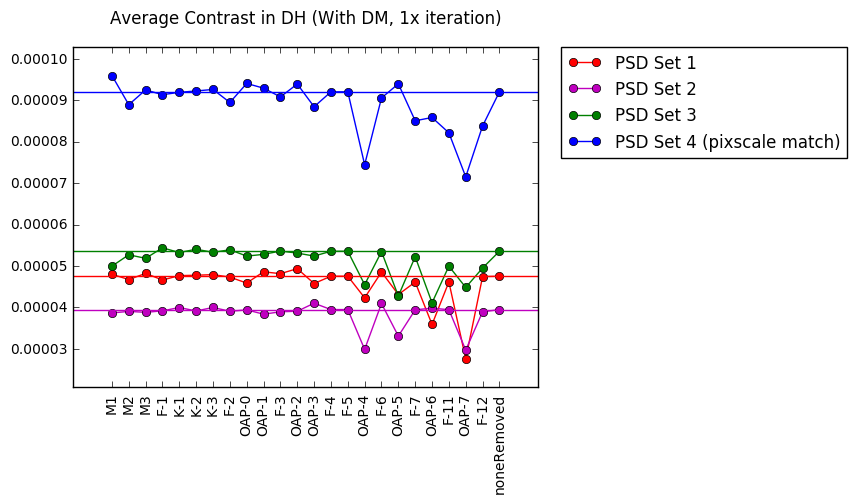

In [14]:
x=np.arange(len(optics_names))
plt.plot(x, set1_withDM_avg, 'ro-', label='PSD Set 1')
plt.plot(x, set2_withDM_avg, 'mo-', label='PSD Set 2')
plt.plot(x, set3_withDM_avg, 'go-', label='PSD Set 3')
plt.plot(x, set4_withDM_avg, 'bo-', label='PSD Set 4 (pixscale match)')
plt.axhline(y=set1_withDM_avg_ref, color='r', linestyle='-')
plt.axhline(y=set2_withDM_avg_ref, color='m', linestyle='-')
plt.axhline(y=set3_withDM_avg_ref, color='g', linestyle='-')
plt.axhline(y=set4_withDM_avg_ref, color='b', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH (With DM, 1x iteration)',y=1.05)
plt.show()

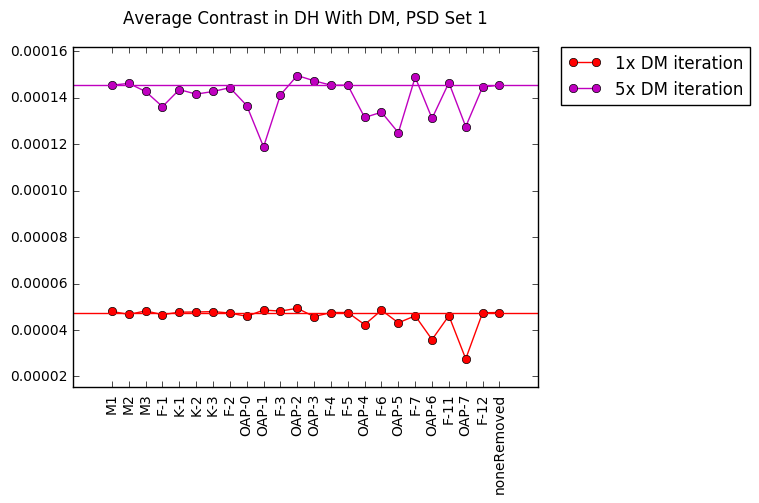

In [15]:
x=np.arange(len(optics_names))
plt.plot(x, set1_withDM_avg, 'ro-', label='1x DM iteration')
plt.plot(x, set1_withDM_5x_avg, 'mo-', label='5x DM iteration')
plt.axhline(y=set1_withDM_avg_ref, color='r', linestyle='-')
plt.axhline(y=set1_withDM_5x_avg_ref, color='m', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH With DM, PSD Set 1',y=1.05)
plt.show()

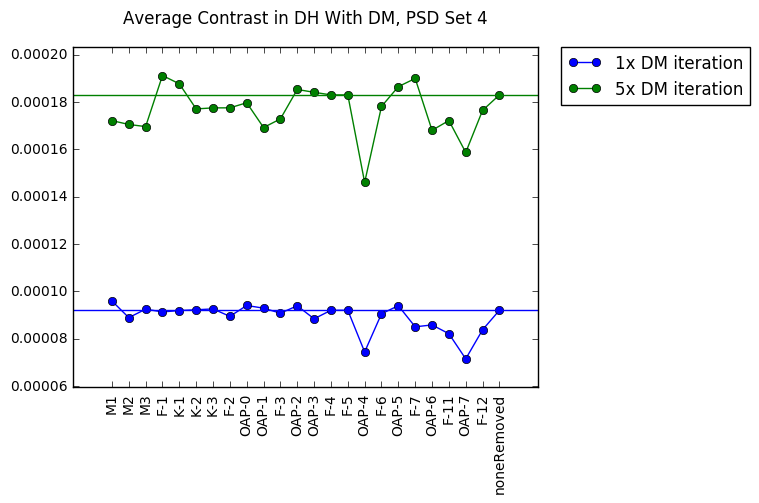

In [16]:
x=np.arange(len(optics_names))
plt.plot(x, set4_withDM_avg, 'bo-', label='1x DM iteration')
plt.plot(x, set4_withDM_5x_avg, 'go-', label='5x DM iteration')
plt.axhline(y=set4_withDM_avg_ref, color='b', linestyle='-')
plt.axhline(y=set4_withDM_5x_avg_ref, color='g', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH With DM, PSD Set 4',y=1.05)
plt.show()

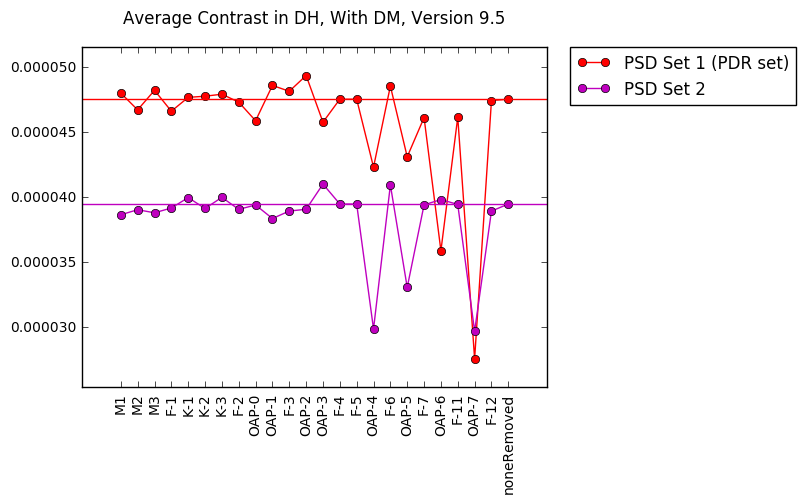

In [8]:
x=np.arange(len(optics_names))
plt.plot(x, set1old_withDM_avg,'ko-', label='PSD Set 1 (old code)')
plt.plot(x, set1_withDM_avg,'ro-', label='PSD Set 1 (new code)')
plt.plot(x, set2_withDM_avg, 'mo-', label='PSD Set 2 (new code)')
plt.axhline(y=set1old_withDM_avg_ref, color='k', linestyle='-')
plt.axhline(y=set1_withDM_avg_ref, color='r', linestyle='-')
plt.axhline(y=set2_withDM_avg_ref, color='m', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH, With DM, Version 9.5',y=1.05)
plt.show()

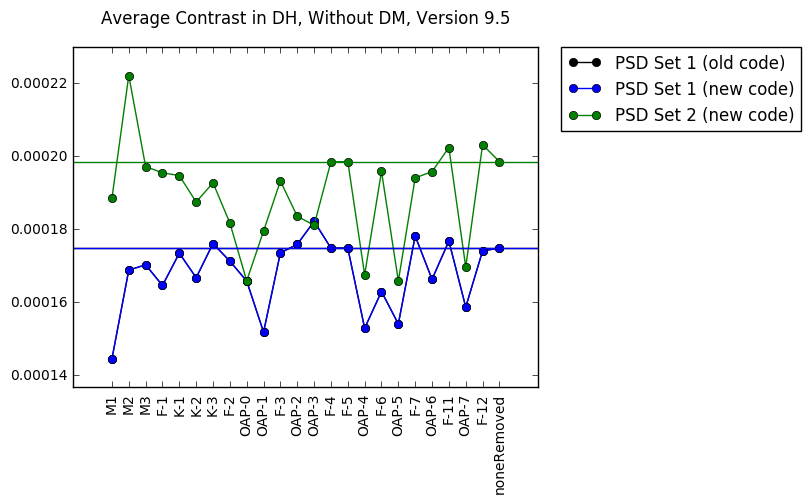

In [18]:
x=np.arange(len(optics_names))
plt.plot(x, set1old_withoutDM_avg,'ko-', label='PSD Set 1 (old code)')
plt.plot(x, set1_withoutDM_avg,'bo-', label='PSD Set 1 (new code)')
plt.plot(x, set2_withoutDM_avg, 'go-', label='PSD Set 2 (new code)')
plt.axhline(y=set1old_withoutDM_avg_ref, color='k', linestyle='-')
plt.axhline(y=set1_withoutDM_avg_ref, color='b', linestyle='-')
plt.axhline(y=set2_withoutDM_avg_ref, color='g', linestyle='-')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(x,optics_names,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('Average Contrast in DH, Without DM, Version 9.5',y=1.05)
plt.show()

## Preparing vAPP files
Here only for reference. Skip if the locations have been determined prior.

In [13]:
vapp_phase_data = fits.open('data/coronagraph/MagAOx_256x256_phase_grating.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAOx_256x256_amp.fits')[0].data

vAPP_folder = 'data/coronagraph/'

#vapp_opd_surf_data = 1*(testWavelength.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vapp_opd_surf_data = 10*(testWavelength.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vAPP_opd_filename = 'vAPP_opd_mask_2PSF_256_x10'
mf.writeOPDfile(vapp_opd_surf_data, vAPP_pixelscl, vAPP_folder + vAPP_opd_filename + '.fits')

#vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
#mf.writeTRANSfile(vapp_aperture_data, vAPP_pixelscl, vAPP_folder + vAPP_trans_filename + '.fits')

# Grated vAPP mask PSF generation
Data to be used for generating focal plane mask placed in F/69 focal plane.

In [19]:
vapp_phase_data = fits.open('data/coronagraph/MagAOx_256x256_phase_grating.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAOx_256x256_amp.fits')[0].data

vAPP_folder = 'data/coronagraph/'

vapp_opd_surf_data = 1*(testWavelength.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vAPP_opd_filename_2PSF = 'vAPP_opd_mask_2PSF_256'
mf.vappOPDfile(vapp_opd_surf_data, vAPP_pixelscl, vAPP_folder + vAPP_opd_filename_2PSF + '.fits')

#vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
#mf.vappTRANSfile(vapp_aperture_data, vAPP_pixelscl, vAPP_folder + vAPP_trans_filename + '.fits')

In [21]:
# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set1_2PSF/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder
tweeter_surf_prefix = 'DMsurf_'
sci_intensity_folder = 'output/v9.5/s256os8x/set1_2PSF/WithDM/'
sci_intensity_prefix = 'SciPSF_WithDM_intensity_'

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('*****')

telescope=[ref_num]

for test_optic in telescope:
    print('Build MagAO-X removing surface: %s' % rx_sys['Name'][test_optic])
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # build to Lyot plane
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
    lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
    lyot_phase_plane_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
    
    # Build Lyot DM surface map routine; spatial plane must be built prior to for-loop
    tweeter_surf_file_loc = tweeter_surf_folder + tweeter_surf_prefix + rx_sys['Name'][test_optic]
    mf.BuildLyotDMSurf(lyot_phase_plane_data, npix, tweeter_diam, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength, tweeter_surf_file_loc)
    
    # Insert Lyot DM map vAPP transmission and OPD optics overrides
    rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + rx_sys['Name'][test_optic]
    rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
    rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_opd_filename_2PSF
    
    # Build science plane PSF with DM and vAPP 
    magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'sci')   
    sci_psf = magaox.calcPSF(wavelength=testWavelength, 
                             display_intermediates=False,
                             return_intermediates=False)
    sci_intensity_loc = sci_intensity_folder + sci_intensity_prefix + rx_sys['Name'][test_optic] + '.fits'
    sci_psf.writeto(sci_intensity_loc, clobber=True)
    
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('End test for %s surface' % rx_sys['Name'][test_optic])
    print('*****')

Surface check using sampling = 256.000000 px and oversampling = 8.000000
*****
Build MagAO-X removing surface: noneRemoved


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

End test for noneRemoved surface
*****
 

## DM correction testing code
Writing some code for testing a 5-iteratiation on the DM to clean up wavefront some more

In [16]:
%%prun

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set1_g0.9/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('Case: With DM')
print('*****')

telescope=[1]
num_DM_iteration = 5
gain = 0.9
tweeter_pixscl = tweeter_diam.value/npix

DM_metric_list = []

for test_optic in telescope:
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # start with no DM surface applied
    tweeter_surf_prefix = 'DMsurf_' + rx_sys['Name'][test_optic] + '_'
    tweeter_surf_addr = tweeter_surf_folder + tweeter_surf_prefix
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    
    # somewhere here will be the DM iteration looping, 5 iterations
    for DM_count in range(0, num_DM_iteration):
        
        if DM_count > 0: # Not the first iteration
            # New DM surface to apply
            DM_new_surf = DM_surf_prev + (gain*calc_surf)
            mf.writeOPDfile(DM_new_surf, tweeter_pixscl, tweeter_surf_addr + str(DM_count) + '.fits')

            # Set up next DM surface for the next Fresnel propagation
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + str(DM_count)
        
        # build to Lyot plane
        magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
        lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
        lyot_phase_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
        
        # Calculate DM surface based on Lyot phase data
        calc_surf = mf.BuildLyotDMSurf(lyot_phase_data, npix, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength)

        # Get previous DM surface
        if DM_count == 0: # First run through
            DM_surf_prev = np.zeros((npix,npix))
        else:
            DM_surf_prev = fits.open(tweeter_surf_addr+str(DM_count-1)+'.fits')[0].data
        
        # metric to see surface change
        DM_metric = np.sum(np.absolute(np.nan_to_num(calc_surf/DM_surf_prev)))
        DM_metric_list.append(DM_metric)
        print('abs value sum: %f' % DM_metric)
        
        if DM_count == (num_DM_iteration-1):
            tweeter_loc = tweeter_surf_prefix + 'final'
            mf.writeOPDfile(calc_surf, tweeter_pixscl, tweeter_surf_folder + tweeter_loc + '.fits')
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_loc
    
    # outside the loop, 
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('%s surface test completed for %s DM surface iterations' % (rx_sys['Name'][test_optic], str(num_DM_iteration)))

Surface check using sampling = 256.000000 px and oversampling = 8.000000
Case: With DM
*****


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

abs value sum: inf
abs value sum: 6753.669884
abs value sum: 1356.226845
abs value sum: 777.309723
abs value sum: 554.518966
M1 surface test completed for 5 DM surface iterations
 

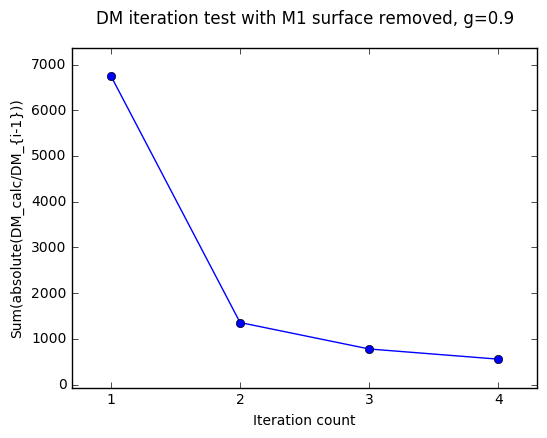

In [17]:
abs_list = DM_metric_list[1:]
x=np.arange(len(abs_list))
plt.plot(x, abs_list,'bo-')
plt.margins(0.1)
plt.xlabel('Iteration count')
plt.xticks(x,x+1)
plt.ylabel('Sum(absolute(DM_calc/DM_{i-1}))')
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('DM iteration test with M1 surface removed, g=0.9',y=1.05)
plt.show()

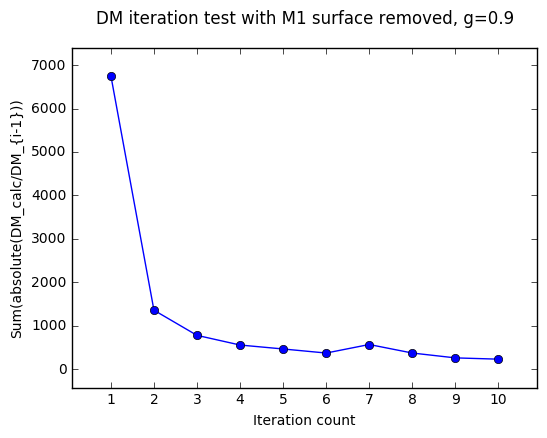

In [27]:
abs_list = [DM_met_1, DM_met_2, DM_met_3, DM_met_4, DM_met_5, DM_met_6, DM_met_7, DM_met_8, DM_met_9, DM_met_10]
x=np.arange(len(abs_list))
plt.plot(x, abs_list,'bo-')
plt.margins(0.1)
plt.xlabel('Iteration count')
plt.xticks(x,x+1)
plt.ylabel('Sum(absolute(DM_calc/DM_{i-1}))')
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('DM iteration test with M1 surface removed, g=0.9',y=1.05)
plt.show()

In [19]:
%%prun

# File address locations
tweeter_surf_folder = 'data/v9.5/s256os8x/set1_g0.4/'
rx_sys['surf_PSD_folder'][tweeter_num] = tweeter_surf_folder

print('Surface check using sampling = %f px and oversampling = %f' % (npix, 1/beam_ratio))
print('Case: With DM')
print('*****')

telescope=[1]
num_DM_iteration = 5
gain = 0.4
tweeter_pixscl = tweeter_diam.value/npix

DM_metric_list = []

for test_optic in telescope:
    
    # Remove test optic PSD and hold the value to change at loop end
    hold_test_PSD = rx_sys['surf_PSD_filename'][test_optic]
    rx_sys['surf_PSD_filename'][test_optic] = 'none'
    
    # start with no DM surface applied
    tweeter_surf_prefix = 'DMsurf_' + rx_sys['Name'][test_optic] + '_'
    tweeter_surf_addr = tweeter_surf_folder + tweeter_surf_prefix
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    
    # somewhere here will be the DM iteration looping, 5 iterations
    for DM_count in range(0, num_DM_iteration):
        
        # build to Lyot plane
        magaox = mf.csvFresnel(rx_sys, npix, beam_ratio, 'lyot')
        lyot_psf, lyot_wfs = magaox.calcPSF(wavelength=testWavelength,
                                    display_intermediates=False,
                                    return_intermediates=True)
        lyot_phase_data = lyot_wfs[len(lyot_wfs)-1].asFITS('phase')[0].data
        
        # Calculate DM surface based on Lyot phase data
        calc_surf = mf.BuildLyotDMSurf(lyot_phase_data, npix, lyot_pupil_base, magKmap, tweeter_BW, 
                       testWavelength)

        # Get previous DM surface
        if DM_count == 0: # First run through
            DM_surf_prev = np.zeros((npix,npix))
        else:
            DM_surf_prev = fits.open(tweeter_surf_addr+str(DM_count-1)+'.fits')[0].data
        
        # metric to see surface change
        DM_metric = np.sum(np.absolute(np.nan_to_num(calc_surf/DM_surf_prev)))
        DM_metric_list.append(DM_metric)
        print('abs value sum: %f' % DM_metric)
        
        if DM_count == (num_DM_iteration-1):
            tweeter_loc = tweeter_surf_prefix + 'final'
            mf.writeOPDfile(calc_surf, tweeter_pixscl, tweeter_surf_folder + tweeter_loc + '.fits')
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_loc
        
        else:
            # New DM surface to apply
            DM_new_surf = DM_surf_prev + (gain*calc_surf)
            mf.writeOPDfile(DM_new_surf, tweeter_pixscl, tweeter_surf_addr + str(DM_count) + '.fits')

            # Set up next DM surface for the next Fresnel propagation
            rx_sys['surf_PSD_filename'][tweeter_num] = tweeter_surf_prefix + str(DM_count)
    
    # outside the loop, 
    # reset corrected optical surfaces
    rx_sys['surf_PSD_filename'][test_optic] = hold_test_PSD
    rx_sys['surf_PSD_filename'][tweeter_num] = 'none'
    rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
    rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'

    print('%s surface test completed for %s DM surface iterations' % (rx_sys['Name'][test_optic], str(num_DM_iteration)))

Surface check using sampling = 256.000000 px and oversampling = 8.000000
Case: With DM
*****


/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]]=resampled_amplitude
/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/jhen/anaconda

abs value sum: inf
abs value sum: 72168.563494
abs value sum: 27413.736154
abs value sum: 13629.962234
abs value sum: 7502.172103
M1 surface test completed for 5 DM surface iterations
 

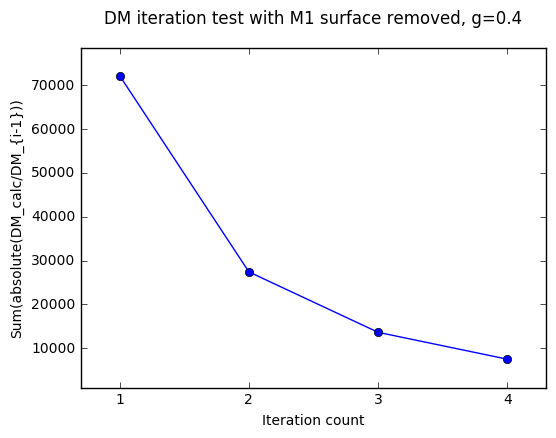

In [20]:
abs_list = DM_metric_list[1:]
x=np.arange(len(abs_list))
plt.plot(x, abs_list,'bo-')
plt.margins(0.1)
plt.xlabel('Iteration count')
plt.xticks(x,x+1)
plt.ylabel('Sum(absolute(DM_calc/DM_{i-1}))')
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
plt.title('DM iteration test with M1 surface removed, g=0.4',y=1.05)
plt.show()